# Janata Hack Demand Forecasting

## Table of Contents

1. [Introduction](#Introduction)
2. [EDA](#EDA)
3. [Data Cleaning](#Data-Cleaning)
4. [Visualizations](#Visualizations)
5. [Modelling](#Modelling)
5. [Neural Network](#Neural-Network)
6. [Predictions](#Predictions)
7. [Conclusion](#Conclusion)
8. [Future Improvements](#Future-Improvements)

## Introduction
AnalyticsVidhya.com hosted a hackathon for forecasting the product sales for different stores. 

---
Problem Statement:
One of the largest retail chains in the world wants to use their vast data source to build an efficient forecasting model to predict the sales for each SKU in its portfolio at its 76 different stores using historical sales data for the past 3 years on a week-on-week basis. Sales and promotional information is also available for each week - product and store wise.

However, no other information regarding stores and products are available. Can you still forecast accurately the sales values for every such product/SKU-store combination for the next 12 weeks accurately? If yes, then dive right in!

---

We approached this problem using common Scikit-Learn classifiers and then comparing the best performing ones with a neural network.

Ultimately, our best performing solution was a Random Forest model which had an R2 score of 0.72 and RMLSE score of 42.

### Library Imports

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import mean_squared_logarithmic_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


allocating expandable gpu memory

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Function to plot accuracy and error for NN

In [4]:
def plot_history(history):
    '''
    Plot model accuracy/loss for training/validation set vs epochs
    
    PARAMS:
        history: Training history from model
    RETURNS:
    '''
    
    fig, axs = plt.subplots(2, figsize=(15,10))
    
    # create accuracy subplots:
    axs[0].plot(history.history['mean_squared_logarithmic_error'], label='train mse')
    axs[0].plot(history.history['val_mean_squared_logarithmic_error'], label='test mse')
    axs[0].set_ylabel('mse')
    axs[0].legend(loc='lower right')
    axs[0].set_title('mse eval')
    
    # create error subplot:
    axs[1].plot(history.history['loss'], label='train error')
    axs[1].plot(history.history['val_loss'], label = 'test error')
    axs[1].set_ylabel('Error')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Error eval')
    
    plt.show()
    

In [7]:
sample_sub = pd.read_csv('test_nfaJ3J5.csv')

## EDA

In [11]:
train = pd.read_csv('train_0irEZ2H.csv')

In [12]:
test = pd.read_csv('test_nfaJ3J5.csv')

In [13]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [14]:
train.tail()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12
150149,212644,09/07/13,9984,679023,234.4125,234.4125,0,0,15


In [15]:
train.shape

(150150, 9)

In [16]:
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0
2,212647,16/07/13,8091,216425,133.9500,133.9500,0,0
3,212648,16/07/13,8091,216233,133.9500,133.9500,0,0
4,212649,16/07/13,8091,217390,176.7000,176.7000,0,0


In [17]:
test.shape

(13860, 8)

In [18]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
record_ID,150150.0,106271.555504,61386.037861,1.000,53111.2500,106226.5000,159452.7500,212644.0000
store_id,150150.0,9199.422511,615.591445,8023.000,8562.0000,9371.0000,9731.0000,9984.0000
sku_id,150150.0,254761.132468,85547.306447,216233.000,217217.0000,222087.0000,245338.0000,679023.0000
total_price,150149.0,206.626751,103.308516,41.325,130.3875,198.0750,233.7000,562.1625
base_price,150150.0,219.425927,110.961712,61.275,133.2375,205.9125,234.4125,562.1625
is_featured_sku,150150.0,0.095611,0.294058,0.000,0.0000,0.0000,0.0000,1.0000
is_display_sku,150150.0,0.133200,0.339792,0.000,0.0000,0.0000,0.0000,1.0000
units_sold,150150.0,51.674206,60.207904,1.000,20.0000,35.0000,62.0000,2876.0000


In [19]:
len(train['sku_id'].unique())

28

In [20]:
len(train['store_id'].unique())

76

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13860 entries, 0 to 13859
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   record_ID        13860 non-null  int64  
 1   week             13860 non-null  object 
 2   store_id         13860 non-null  int64  
 3   sku_id           13860 non-null  int64  
 4   total_price      13860 non-null  float64
 5   base_price       13860 non-null  float64
 6   is_featured_sku  13860 non-null  int64  
 7   is_display_sku   13860 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 866.4+ KB


## Data Cleaning

### Checking for Nulls

In [24]:
train.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [25]:
test.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
dtype: int64

In [26]:
train[train['total_price'].isnull()]

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
136949,193915,23/04/13,9436,245338,NaN,469.5375,0,0,1


### Imputing values for nulls

 'total_price' mean value for null

In [28]:
train[(train['store_id'] == 9436) & (train['sku_id']==245338)]['total_price'].mean()

422.4959302325582

In [29]:
# impute mean value

In [30]:
train.loc[(train['total_price'].isnull()), 'total_price'] = 422.4959302325578

In [31]:
# check for nulls again

In [32]:
train[train['total_price'].isnull()]
# all good no nulls

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold


### convert week to datetime

train dataset

In [34]:
train['week'] = pd.to_datetime(train['week'])

In [35]:
train['week'].dtype

dtype('<M8[ns]')

test dataset

In [37]:
test['week'] = pd.to_datetime(test['week'])

In [38]:
test['week'].dtype

dtype('<M8[ns]')

### separate 'day of year' and 'year' from datetime

In [39]:
train['day_of_year'] = train['week'].dt.dayofyear

In [40]:
test['day_of_year'] = test['week'].dt.dayofyear

In [41]:
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,day_of_year
0,212645,2013-07-16,8091,216418,108.3000,108.3000,0,0,197
1,212646,2013-07-16,8091,216419,109.0125,109.0125,0,0,197
2,212647,2013-07-16,8091,216425,133.9500,133.9500,0,0,197
3,212648,2013-07-16,8091,216233,133.9500,133.9500,0,0,197
4,212649,2013-07-16,8091,217390,176.7000,176.7000,0,0,197


In [42]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day_of_year
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,17
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,17
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,17
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,17
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,17


In [43]:
train.tail()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day_of_year
150145,212638,2013-09-07,9984,223245,235.8375,235.8375,0,0,38,250
150146,212639,2013-09-07,9984,223153,235.8375,235.8375,0,0,30,250
150147,212642,2013-09-07,9984,245338,357.6750,483.7875,1,1,31,250
150148,212643,2013-09-07,9984,547934,141.7875,191.6625,0,1,12,250
150149,212644,2013-09-07,9984,679023,234.4125,234.4125,0,0,15,250


In [44]:
train['year'] = pd.DatetimeIndex(train['week']).year

In [45]:
test['year'] = pd.DatetimeIndex(test['week']).year

In [46]:
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,day_of_year,year
0,212645,2013-07-16,8091,216418,108.3000,108.3000,0,0,197,2013
1,212646,2013-07-16,8091,216419,109.0125,109.0125,0,0,197,2013
2,212647,2013-07-16,8091,216425,133.9500,133.9500,0,0,197,2013
3,212648,2013-07-16,8091,216233,133.9500,133.9500,0,0,197,2013
4,212649,2013-07-16,8091,217390,176.7000,176.7000,0,0,197,2013


In [47]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day_of_year,year
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,17,2011
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,17,2011
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,17,2011
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,17,2011
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,17,2011


In [48]:
train.tail()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day_of_year,year
150145,212638,2013-09-07,9984,223245,235.8375,235.8375,0,0,38,250,2013
150146,212639,2013-09-07,9984,223153,235.8375,235.8375,0,0,30,250,2013
150147,212642,2013-09-07,9984,245338,357.6750,483.7875,1,1,31,250,2013
150148,212643,2013-09-07,9984,547934,141.7875,191.6625,0,1,12,250,2013
150149,212644,2013-09-07,9984,679023,234.4125,234.4125,0,0,15,250,2013


### convert 'store_id' and 'sku_id' to str

In [50]:
train['store_id'] = train['store_id'].astype(int).astype(str)

In [51]:
train['sku_id'] = train['sku_id'].astype(int).astype(str)

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   record_ID        150150 non-null  int64         
 1   week             150150 non-null  datetime64[ns]
 2   store_id         150150 non-null  object        
 3   sku_id           150150 non-null  object        
 4   total_price      150150 non-null  float64       
 5   base_price       150150 non-null  float64       
 6   is_featured_sku  150150 non-null  int64         
 7   is_display_sku   150150 non-null  int64         
 8   units_sold       150150 non-null  int64         
 9   day_of_year      150150 non-null  int64         
 10  year             150150 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 12.6+ MB


In [53]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13860 entries, 0 to 13859
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   record_ID        13860 non-null  int64         
 1   week             13860 non-null  datetime64[ns]
 2   store_id         13860 non-null  int64         
 3   sku_id           13860 non-null  int64         
 4   total_price      13860 non-null  float64       
 5   base_price       13860 non-null  float64       
 6   is_featured_sku  13860 non-null  int64         
 7   is_display_sku   13860 non-null  int64         
 8   day_of_year      13860 non-null  int64         
 9   year             13860 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7)
memory usage: 1.1 MB


### combine sku and store into a new col

In [55]:
train['store_sku'] = train[['store_id', 'sku_id']].agg('-'.join, axis=1)

In [56]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day_of_year,year,store_sku
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,17,2011,8091-216418
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,17,2011,8091-216419
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,17,2011,8091-216425
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,17,2011,8091-216233
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,17,2011,8091-217390


In [57]:
train.tail()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day_of_year,year,store_sku
150145,212638,2013-09-07,9984,223245,235.8375,235.8375,0,0,38,250,2013,9984-223245
150146,212639,2013-09-07,9984,223153,235.8375,235.8375,0,0,30,250,2013,9984-223153
150147,212642,2013-09-07,9984,245338,357.6750,483.7875,1,1,31,250,2013,9984-245338
150148,212643,2013-09-07,9984,547934,141.7875,191.6625,0,1,12,250,2013,9984-547934
150149,212644,2013-09-07,9984,679023,234.4125,234.4125,0,0,15,250,2013,9984-679023


In [58]:
len(train['store_sku'].unique())

1155

In [59]:
train['store_id'].value_counts()

8094    3120
9823    2990
8991    2990
8438    2730
8023    2730
        ... 
9439    1170
8091    1170
9178     780
9700     650
9001     260
Name: store_id, Length: 76, dtype: int64

## Visualizations

Checking 'units sold' for outliers

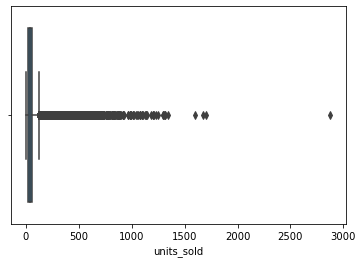

In [60]:
sns.boxplot(train['units_sold']);

In [61]:
train[train['units_sold'] > 1500]

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day_of_year,year,store_sku
5559,7894,2011-02-14,9823,219009,118.9875,227.2875,1,0,1599,45,2011,9823-219009
5607,7961,2011-02-14,9845,219009,116.8500,227.2875,1,1,2876,45,2011,9845-219009
6762,9598,2011-02-21,9845,219009,114.0000,227.2875,0,1,1669,52,2011,9845-219009
7917,11210,2011-02-28,9845,219009,116.8500,227.2875,1,1,1705,59,2011,9845-219009


removing outliers

In [62]:
train = train[train['units_sold'] < 1500]

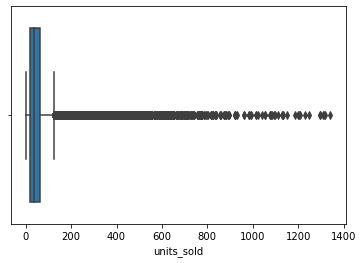

In [63]:
sns.boxplot(train['units_sold']);

In [64]:
train['units_sold'].max()

1341

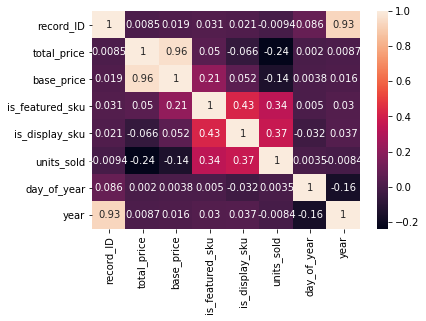

In [66]:
sns.heatmap(train.corr(),annot=True);

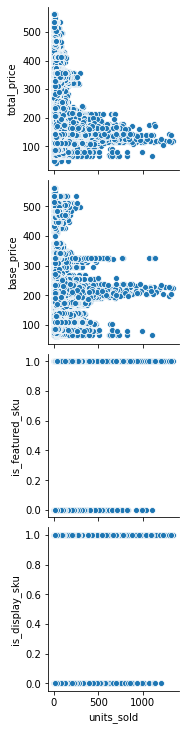

In [ ]:
sns.pairplot(train, y_vars = ['total_price', 'base_price', 'is_featured_sku', 'is_display_sku'], x_vars = 'units_sold')

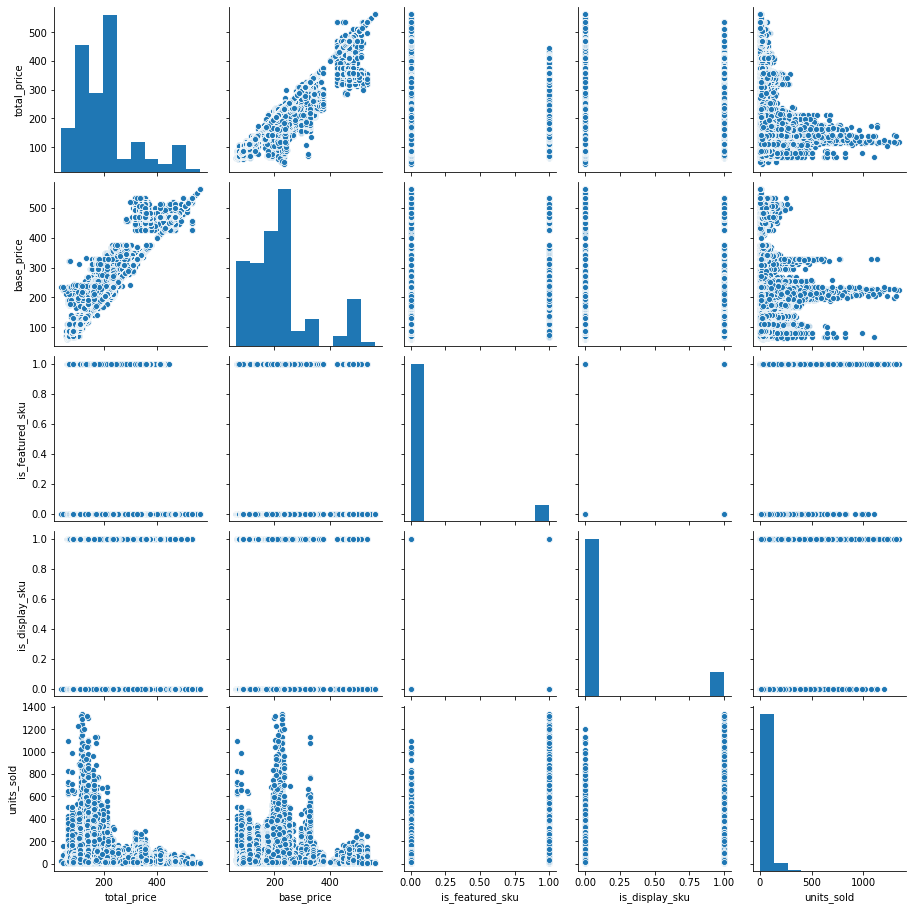

In [ ]:
sns.pairplot(train, y_vars = ['total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'units_sold'], x_vars = ['total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'units_sold'])

## Modelling

function to calculate rmsle*100 per hackathon scoring (root mean squared log error)

In [68]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))*100

### baseline scoring

In [70]:
baseline = [train['units_sold'].mean() for i in range(len(train))]

In [71]:
print(rmsle(train['units_sold'], baseline))

93.96352447206748


### initial modelling

In [65]:
train['store_id'] = train['store_id'].astype(int)
train['sku_id'] = train['sku_id'].astype(int)

In [66]:
test['store_id'] = test['store_id'].astype(int)
test['sku_id'] = test['sku_id'].astype(int)

In [67]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day_of_year,year,store_sku
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,17,2011,8091-216418
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,17,2011,8091-216419
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,17,2011,8091-216425
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,17,2011,8091-216233
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,17,2011,8091-217390


### Train/Test split

In [68]:
X = train[['store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'day_of_year', 'year']]
y = train['units_sold']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [79]:
X_train.shape

(90087, 8)

In [80]:
X_validation.shape

(22522, 8)

In [81]:
X_test.shape

(37537, 8)

In [83]:
rf = RandomForestRegressor()

In [85]:
cross_val_score(rf, X_train, y_train, cv = 5).mean()

0.7458953010297646

In [86]:
rf_model = rf.fit(X_train, y_train)

In [88]:
rf_trainpreds = rf_model.predict(X_train)
rf_valpreds = rf_model.predict(X_validation)

In [89]:
print(r2_score(y_train, rf_trainpreds))
print(r2_score(y_validation, rf_valpreds))
print(rmsle(y_train, rf_trainpreds))
print(rmsle(y_validation, rf_valpreds))

0.9655064036076364
0.7232145881883801
19.448662550069283
42.604223673358014


In [90]:
rf_testpreds = rf_model.predict(X_test)

In [92]:
print(r2_score(y_test, rf_testpreds))
print(rmsle(y_test, rf_testpreds))

0.7537517734317896
42.89273278538715


In [ ]:
X_train.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,day_of_year,year
51467,9432,245338,395.4375,469.5375,1,1,325,2011
54000,9731,223245,178.1250,227.2875,0,0,132,2011
20090,9190,219029,301.3875,301.3875,0,0,136,2011
76341,8222,216233,118.2750,133.9500,0,0,115,2012
147164,9250,216419,109.7250,109.7250,0,1,176,2013


## Neural Network

In [163]:
model1 = Sequential()
model1.add(Dense(16, input_dim = X_train.shape[1], activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation = 'linear'))

In [164]:
#compile NN
model1.compile(loss = 'mse', optimizer = 'sgd', metrics=[tf.keras.metrics.MeanSquaredLogarithmicError()])

In [165]:
early_stop = EarlyStopping(monitor = 'val_mean_squared_logarithmic_error', patience = 5, min_delta = 0, restore_best_weights = True)

In [166]:
model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_23 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 17        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [167]:
history = model1.fit(X_train, y_train,
                     validation_data=(X_validation, y_validation),
                     epochs=20,
                     batch_size=32,
                     callbacks = [early_stop]
                     )

Train on 90087 samples, validate on 22522 samples
Epoch 1/20
90087/90087 [==============================] - 5s 56us/step - loss: inf - mean_squared_logarithmic_error: 663.5485 - val_loss: 3699.2593 - val_mean_squared_logarithmic_error: 264.3929
Epoch 2/20
90087/90087 [==============================] - 5s 56us/step - loss: 3511.2101 - mean_squared_logarithmic_error: 174.4114 - val_loss: 3697.1769 - val_mean_squared_logarithmic_error: 125.3141
Epoch 3/20
90087/90087 [==============================] - 5s 56us/step - loss: 3511.0453 - mean_squared_logarithmic_error: 100.2249 - val_loss: 3698.6044 - val_mean_squared_logarithmic_error: 82.3659
Epoch 4/20
90087/90087 [==============================] - 5s 61us/step - loss: 3511.3813 - mean_squared_logarithmic_error: 70.6780 - val_loss: 3700.2072 - val_mean_squared_logarithmic_error: 61.4623
Epoch 5/20
90087/90087 [==============================] - 5s 56us/step - loss: 3511.1966 - mean_squared_logarithmic_error: 54.7140 - val_loss: 3697.1334 - 

In [ ]:
rf_testpreds

array([23.72,  9.52, 68.64, ..., 28.79, 49.06, 36.68])

In [ ]:
nn1_testset = pd.Series([nn1_testsetpreds])

In [ ]:
nn1_testset

0    [[51.582718], [51.582718], [51.582718], [51.58...
dtype: object

In [ ]:
test['units_sold'] = nn1_testsetpreds

In [ ]:
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0,51.582718
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0,51.582718
2,212647,16/07/13,8091,216425,133.9500,133.9500,0,0,51.582718
3,212648,16/07/13,8091,216233,133.9500,133.9500,0,0,51.582718
4,212649,16/07/13,8091,217390,176.7000,176.7000,0,0,51.582718


In [ ]:
submission = test.drop(columns=['week','store_id','store_id','sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku'])

In [ ]:
submission

,record_ID,units_sold
0,212645,51.582718
1,212646,51.582718
2,212647,51.582718
3,212648,51.582718
4,212649,51.582718
...,...,...
13855,232281,51.582718
13856,232282,51.582718
13857,232285,51.582718
13858,232286,51.582718


In [ ]:
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,day_of_year,year
0,212645,2013-07-16,8091,216418,108.3000,108.3000,0,0,197,2013
1,212646,2013-07-16,8091,216419,109.0125,109.0125,0,0,197,2013
2,212647,2013-07-16,8091,216425,133.9500,133.9500,0,0,197,2013
3,212648,2013-07-16,8091,216233,133.9500,133.9500,0,0,197,2013
4,212649,2013-07-16,8091,217390,176.7000,176.7000,0,0,197,2013


In [ ]:
test_df = test.drop(columns=['record_ID', 'week'])

In [ ]:
submission_rf = rf_model.predict(test_df)

In [ ]:
submission_rf

array([22.61, 21.52, 36.77, ..., 38.27, 11.91,  7.72])

In [ ]:
submission_rf.astype(int)

array([22, 21, 36, ..., 38, 11,  7])

In [ ]:
submission.drop(columns='units_sold', inplace=True)

In [ ]:
submission['units_sold'] = submission_rf.astype(int)

### Feature engineering

In [63]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day_of_year,year,store_sku
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,17,2011,8091-216418
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,17,2011,8091-216419
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,17,2011,8091-216425
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,17,2011,8091-216233
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,17,2011,8091-217390


In [69]:
train['price_diff'] = train['base_price'] - train['total_price']

In [70]:
train['units_sold_prev_week'] = train['units_sold'].shift(1)

In [71]:
train.dropna(inplace=True)

In [72]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day_of_year,year,store_sku,price_diff,units_sold_prev_week
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,17,2011,8091-216419,0.0,20.0
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,17,2011,8091-216425,0.0,28.0
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,17,2011,8091-216233,0.0,19.0
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,17,2011,8091-217390,0.0,44.0
5,9,2011-01-17,8091,219009,227.2875,227.2875,0,0,18,17,2011,8091-219009,0.0,52.0


In [250]:
X = train[['store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'day_of_year', 'year', 'price_diff', 'units_sold_prev_week']]
y = train['units_sold']

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [252]:
X_train.shape

(90086, 10)

In [253]:
# sc = StandardScaler()
# X_train_sc = sc.fit_transform(X_train)
# X_val_sc = sc.transform(X_validation)
# X_test_sc = sc.transform(X_test)

In [258]:
X_train.shape

(90086, 10)

In [255]:
rf2 = RandomForestRegressor()

In [257]:
cross_val_score(rf2, X_train, y_train, cv = 5).mean()

0.7460383142123538

In [259]:
rf_model2 = rf2.fit(X_train, y_train)

In [260]:
rf_trainpreds_2 = rf_model2.predict(X_train)
rf_valpreds_2 = rf_model2.predict(X_validation)

In [261]:
print(r2_score(y_train, rf_trainpreds_2))
print(r2_score(y_validation, rf_valpreds_2))
print(rmsle(y_train, rf_trainpreds_2))
print(rmsle(y_validation, rf_valpreds_2))

0.9657821029561751
0.7847628135559948
20.29737259276497
43.896642917488506


In [262]:
rf_testpreds_2 = rf_model2.predict(X_test)

In [263]:
print(r2_score(y_test, rf_testpreds_2))
print(rmsle(y_test, rf_testpreds_2))

0.7688877568755238
43.41657929466414


### Poly features

In [73]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day_of_year,year,store_sku,price_diff,units_sold_prev_week
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,17,2011,8091-216419,0.0,20.0
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,17,2011,8091-216425,0.0,28.0
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,17,2011,8091-216233,0.0,19.0
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,17,2011,8091-217390,0.0,44.0
5,9,2011-01-17,8091,219009,227.2875,227.2875,0,0,18,17,2011,8091-219009,0.0,52.0


In [74]:
features = ['total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'price_diff', 'units_sold_prev_week']

In [75]:
# Instantiate PolynomialFeatures

poly = PolynomialFeatures(include_bias=False)

In [76]:
train_feat = train[features]

In [77]:
# Create X_poly
train_poly = poly.fit_transform(train_feat)

train_poly.shape

(150145, 27)

In [78]:
train_poly_df = pd.DataFrame(train_poly,columns=poly.get_feature_names(features))

In [79]:
train_poly_df.head()

,total_price,base_price,is_featured_sku,is_display_sku,price_diff,units_sold_prev_week,total_price^2,total_price base_price,total_price is_featured_sku,total_price is_display_sku,...,is_featured_sku^2,is_featured_sku is_display_sku,is_featured_sku price_diff,is_featured_sku units_sold_prev_week,is_display_sku^2,is_display_sku price_diff,is_display_sku units_sold_prev_week,price_diff^2,price_diff units_sold_prev_week,units_sold_prev_week^2
0,99.0375,99.0375,0.0,0.0,0.0,20.0,9808.426406,9808.426406,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0
1,133.9500,133.9500,0.0,0.0,0.0,28.0,17942.602500,17942.602500,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,784.0
2,133.9500,133.9500,0.0,0.0,0.0,19.0,17942.602500,17942.602500,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,361.0
3,141.0750,141.0750,0.0,0.0,0.0,44.0,19902.155625,19902.155625,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1936.0
4,227.2875,227.2875,0.0,0.0,0.0,52.0,51659.607656,51659.607656,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2704.0


In [80]:
train_poly_model = train.drop(columns=features)

In [81]:
train_poly_model.head()

,record_ID,week,store_id,sku_id,units_sold,day_of_year,year,store_sku
1,2,2011-01-17,8091,216419,28,17,2011,8091-216419
2,3,2011-01-17,8091,216425,19,17,2011,8091-216425
3,4,2011-01-17,8091,216233,44,17,2011,8091-216233
4,5,2011-01-17,8091,217390,52,17,2011,8091-217390
5,9,2011-01-17,8091,219009,18,17,2011,8091-219009


In [82]:
train_poly_model = pd.merge(train_poly_model, train_poly_df, how='inner', left_index=True, right_index=True)

In [83]:
train_poly_model.head()

,record_ID,week,store_id,sku_id,units_sold,day_of_year,year,store_sku,total_price,base_price,...,is_featured_sku^2,is_featured_sku is_display_sku,is_featured_sku price_diff,is_featured_sku units_sold_prev_week,is_display_sku^2,is_display_sku price_diff,is_display_sku units_sold_prev_week,price_diff^2,price_diff units_sold_prev_week,units_sold_prev_week^2
1,2,2011-01-17,8091,216419,28,17,2011,8091-216419,133.9500,133.9500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,784.0
2,3,2011-01-17,8091,216425,19,17,2011,8091-216425,133.9500,133.9500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,361.0
3,4,2011-01-17,8091,216233,44,17,2011,8091-216233,141.0750,141.0750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1936.0
4,5,2011-01-17,8091,217390,52,17,2011,8091-217390,227.2875,227.2875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2704.0
5,9,2011-01-17,8091,219009,18,17,2011,8091-219009,327.0375,327.0375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,324.0


In [84]:
train_poly_model.columns

Index(['record_ID', 'week', 'store_id', 'sku_id', 'units_sold', 'day_of_year',
       'year', 'store_sku', 'total_price', 'base_price', 'is_featured_sku',
       'is_display_sku', 'price_diff', 'units_sold_prev_week', 'total_price^2',
       'total_price base_price', 'total_price is_featured_sku',
       'total_price is_display_sku', 'total_price price_diff',
       'total_price units_sold_prev_week', 'base_price^2',
       'base_price is_featured_sku', 'base_price is_display_sku',
       'base_price price_diff', 'base_price units_sold_prev_week',
       'is_featured_sku^2', 'is_featured_sku is_display_sku',
       'is_featured_sku price_diff', 'is_featured_sku units_sold_prev_week',
       'is_display_sku^2', 'is_display_sku price_diff',
       'is_display_sku units_sold_prev_week', 'price_diff^2',
       'price_diff units_sold_prev_week', 'units_sold_prev_week^2'],
      dtype='object')

In [85]:
X = train_poly_model[['store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'day_of_year', 'year', 'price_diff', 'units_sold_prev_week', 'total_price^2',
       'total_price base_price', 'total_price is_featured_sku',
       'total_price is_display_sku', 'total_price price_diff',
       'total_price units_sold_prev_week', 'base_price^2',
       'base_price is_featured_sku', 'base_price is_display_sku',
       'base_price price_diff', 'base_price units_sold_prev_week',
       'is_featured_sku^2', 'is_featured_sku is_display_sku',
       'is_featured_sku price_diff', 'is_featured_sku units_sold_prev_week',
       'is_display_sku^2', 'is_display_sku price_diff',
       'is_display_sku units_sold_prev_week', 'price_diff^2',
       'price_diff units_sold_prev_week', 'units_sold_prev_week^2']]
y = train_poly_model['units_sold']

In [86]:
X['store_id'] = X['store_id'].astype(int).astype(str)

<ipython-input-86-364324d164ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['store_id'] = X['store_id'].astype(int).astype(str)


In [87]:
X['sku_id'] = X['sku_id'].astype(int).astype(str)

<ipython-input-87-33ab4a837f44>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sku_id'] = X['sku_id'].astype(int).astype(str)


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [89]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96089 entries, 20006 to 136993
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   store_id                              96089 non-null  object 
 1   sku_id                                96089 non-null  object 
 2   total_price                           96089 non-null  float64
 3   base_price                            96089 non-null  float64
 4   is_featured_sku                       96089 non-null  float64
 5   is_display_sku                        96089 non-null  float64
 6   day_of_year                           96089 non-null  int64  
 7   year                                  96089 non-null  int64  
 8   price_diff                            96089 non-null  float64
 9   units_sold_prev_week                  96089 non-null  float64
 10  total_price^2                         96089 non-null  float64
 11  total_pric

In [90]:
X_train.shape

(96089, 31)

In [91]:
X_validation.shape

(24023, 31)

In [92]:
X_test.shape

(30028, 31)

### NN

In [93]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_validation)
X_test_sc = sc.transform(X_test)

In [89]:
model5 = Sequential()
model5.add(Dense(16, input_dim = X_train_sc.shape[1], activation = 'relu'))
model5.add(Dropout(0.5))
model5.add(Dense(16, activation = 'relu'))
model5.add(Dropout(0.5))
model5.add(Dense(32, activation = 'relu'))
model5.add(Dropout(0.5))
model5.add(Dense(32, activation = 'relu'))
model5.add(Dropout(0.5))
model5.add(Dense(1, activation = 'linear'))

In [90]:
#compile NN
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# model5.compile(loss = 'mse', optimizer = optimizer, metrics=[tf.keras.metrics.MeanSquaredLogarithmicError()])
model5.compile(loss='mean_squared_logarithmic_error', optimizer = 'adam', metrics=['mse'])

In [91]:
# early_stop = EarlyStopping(monitor = 'val_mean_squared_logarithmic_error', patience = 3, min_delta = 0, restore_best_weights = True)
early_stop = EarlyStopping(monitor = 'val_mse', patience = 20, min_delta = 0, restore_best_weights = True)

In [92]:
model5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [117]:
model6 = Sequential()
model6.add(Dense(16, input_dim = X_train_sc.shape[1], activation = 'relu'))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation = 'relu'))
model6.add(Dropout(0.5))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dropout(0.5))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dropout(0.5))

model6.add(Dense(1, activation = 'linear'))

In [118]:
#compile NN
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model6.compile(loss = 'mse', optimizer = optimizer, metrics=[tf.keras.metrics.MeanSquaredLogarithmicError()])
# model6.compile(loss='mean_squared_logarithmic_error', optimizer = 'adam', metrics=['mse'])

In [119]:
# early_stop = EarlyStopping(monitor = 'val_mean_squared_logarithmic_error', patience = 3, min_delta = 0, restore_best_weights = True)
# early_stop = EarlyStopping(monitor = 'val_mse', patience = 20, min_delta = 0, restore_best_weights = True)
early_stop = EarlyStopping(monitor = 'val_loss', patience = 20, min_delta = 0, restore_best_weights = True)

In [120]:
model6.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                512       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                1088      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)              

In [121]:
history = model6.fit(X_train_sc, y_train,
                     validation_data=(X_val_sc, y_validation),
                     epochs=100,
                     batch_size=8,
                     callbacks = [early_stop]
                     )

Train on 96089 samples, validate on 24023 samples
Epoch 1/100
96089/96089 [==============================] - 22s 230us/step - loss: 4632.6232 - mean_squared_logarithmic_error: 5.2660 - val_loss: 4388.5820 - val_mean_squared_logarithmic_error: 2.4351
Epoch 2/100
96089/96089 [==============================] - 22s 225us/step - loss: 3892.2013 - mean_squared_logarithmic_error: 1.9246 - val_loss: 4223.8578 - val_mean_squared_logarithmic_error: 1.6382
Epoch 3/100
96089/96089 [==============================] - 22s 227us/step - loss: 3742.5612 - mean_squared_logarithmic_error: 1.4843 - val_loss: 4106.6212 - val_mean_squared_logarithmic_error: 1.3731
Epoch 4/100
96089/96089 [==============================] - 22s 227us/step - loss: 3669.5497 - mean_squared_logarithmic_error: 1.2973 - val_loss: 4038.0755 - val_mean_squared_logarithmic_error: 1.2367
Epoch 5/100
96089/96089 [==============================] - 22s 229us/step - loss: 3588.6555 - mean_squared_logarithmic_error: 1.1913 - val_loss: 4019.

Epoch 82/100
96089/96089 [==============================] - 22s 227us/step - loss: 3253.5240 - mean_squared_logarithmic_error: 0.8030 - val_loss: 3757.9796 - val_mean_squared_logarithmic_error: 0.8028
Epoch 83/100
96089/96089 [==============================] - 22s 227us/step - loss: 3266.6368 - mean_squared_logarithmic_error: 0.8024 - val_loss: 3753.9102 - val_mean_squared_logarithmic_error: 0.8022
Epoch 84/100
96089/96089 [==============================] - 22s 233us/step - loss: 3280.9492 - mean_squared_logarithmic_error: 0.8019 - val_loss: 3740.0509 - val_mean_squared_logarithmic_error: 0.8017
Epoch 85/100
96089/96089 [==============================] - 22s 230us/step - loss: 3257.2158 - mean_squared_logarithmic_error: 0.8014 - val_loss: 3747.4856 - val_mean_squared_logarithmic_error: 0.8012
Epoch 86/100
96089/96089 [==============================] - 22s 231us/step - loss: 3275.1523 - mean_squared_logarithmic_error: 0.8009 - val_loss: 3753.7931 - val_mean_squared_logarithmic_error: 0.

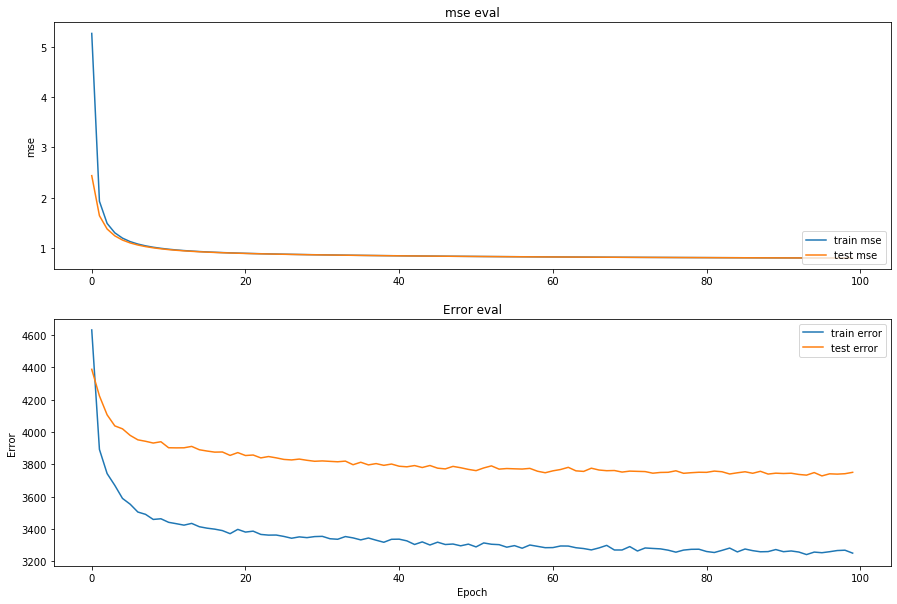

In [133]:
plot_history(history)

## Predictions

In [169]:
# function to calculate rmsle*100 per hackathon scoring
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))*100

#### RF

In [294]:
rf = RandomForestRegressor()

In [296]:
cross_val_score(rf, X_train, y_train, cv = 5).mean()

0.6181031553333474

In [297]:
rf_model_3 = rf.fit(X_train, y_train)

In [298]:
rf_trainpreds_3 = rf_model_3.predict(X_train)
rf_valpreds_3 = rf_model_3.predict(X_validation)

In [299]:
print(r2_score(y_train, rf_trainpreds_3))
print(r2_score(y_validation, rf_valpreds_3))
print(rmsle(y_train, rf_trainpreds_3))
print(rmsle(y_validation, rf_valpreds_3))

0.9487979675294066
0.6550038559856852
24.863166081949032
52.531358164106024


In [300]:
rf_testpreds_3 = rf_model_3.predict(X_test)

In [301]:
print(r2_score(y_test, rf_testpreds_3))
print(rmsle(y_test, rf_testpreds_3))

0.6450372280688308
51.98074578087022


#### NN

In [168]:
nn1_trainpreds = model1.predict(X_train)
nn1_valpreds = model1.predict(X_validation)
nn1_testpreds = model1.predict(X_test)

In [170]:

print(rmsle(y_train, nn1_trainpreds))
print(rmsle(y_validation, nn1_valpreds))
print(rmsle(y_test, nn1_testpreds))

93.29973995239669
92.67630648979292
92.84792090662602


In [ ]:
# prediction for test set

In [ ]:
test.drop(columns=['record_ID', 'week', 'units_sold'], inplace=True)

In [ ]:
test.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,8091,216418,108.3000,108.3000,0,0
1,8091,216419,109.0125,109.0125,0,0
2,8091,216425,133.9500,133.9500,0,0
3,8091,216233,133.9500,133.9500,0,0
4,8091,217390,176.7000,176.7000,0,0


In [ ]:
nn1_testsetpreds = model1.predict(test)

In [469]:
nn5_trainpreds = model5.predict(X_train_sc)
nn5_valpreds = model5.predict(X_val_sc)


In [471]:

print(rmsle(y_train, nn5_trainpreds))
print(rmsle(y_validation, nn5_valpreds))


79.51707571723557
79.93250020708561


In [474]:
nn5_testpreds = model5.predict(X_test_sc)

In [475]:
print(rmsle(y_test, nn5_testpreds))

79.25530747295123


In [122]:
nn6_trainpreds = model6.predict(X_train_sc)
nn6_valpreds = model6.predict(X_val_sc)


In [124]:

print(rmsle(y_train, nn6_trainpreds))
print(rmsle(y_validation, nn6_valpreds))


83.09186577827245
82.62090055545175


In [127]:
nn6_testpreds = model6.predict(X_test_sc)

In [128]:
print(rmsle(y_test, nn6_testpreds))

82.08814315413747


### Submission

In [3]:
submission_sample = pd.read_csv('./sample_submission_pzljTaX.csv')

In [4]:
submission_sample.drop(columns='units_sold', inplace=True)

In [5]:
submission_sample['units_sold'] = rf_model2.predict(X_test).astype(int)

In [6]:
submission_sample.to_csv('submission_rf.csv', index=False) 

## Conclusion

The Random Forest model was the best solution based on our results and achieved a R2 score of 0.72 and RMLSE of 42 on the test dataset. While we did attempt a neural network solution as well it was overfit and the predictions failed to outperform the Random Forest model.

## Future Improvements
Areas of improvement in the future include better feature engineering to create new relations between the features and additional hyperparameter tuning on the Scikit-Learn classifiers and also additional tuning for the neural network.
